In [0]:
from __future__ import print_function, division, unicode_literals

import numpy as np
import os
import tensorflow as tf

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  np.random.seed(seed)


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "/tmp/"
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

A couple utility functions to plot grayscale and RGB images:

In [0]:
def plot_image(image):
  plt.imshow(image,cmap="gray", interpolation="nearest")
  plt.axis("off")

def plot_color_image(image):
  plt.imshow(image.astype(np.uint8), interpolation="nearest")
  plt.axis("off")

Convolutional layer

In [0]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image=china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale=image.mean(axis=2).astype(np.float32)
images=image_grayscale.reshape(1, height, width,1)

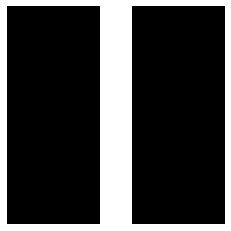

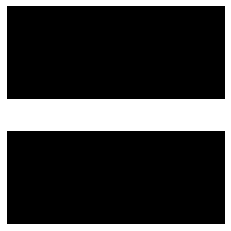

In [4]:
fmap = np.zeros(shape=(7,7,1,2), dtype=np.float32)
fmap[:,3,0,0]=1
fmap[3,:,0,1]=1
plot_image(fmap[:,:,0,0])
plt.show()
plot_image(fmap[:,:,0,1])
plt.show()

In [0]:
reset_graph()

X=tf.placeholder(tf.float32, shape=(None, height, width,1))
feature_maps=tf.constant(fmap)
convolution=tf.nn.conv2d(X,feature_maps, strides=[1,1,1,1],padding="SAME")

In [0]:
with tf.Session() as sess:
  output=convolution.eval(feed_dict={X:images})

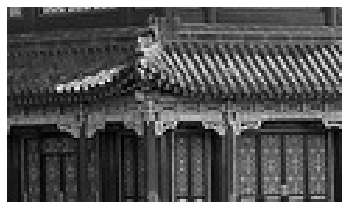

In [7]:
plot_image(images[0,:,:,0])
# save_fig("china_original", tight_layout=False)
plt.show()

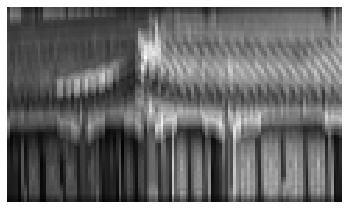

In [8]:
plot_image(output[0,:,:,0])
plt.show()

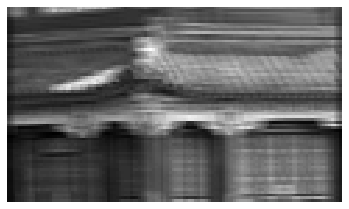

In [9]:
plot_image(output[0,:,:,1])
plt.show()

Simple example

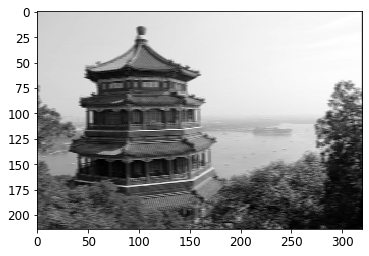

In [10]:
import numpy as np
from sklearn.datasets import load_sample_images

# load sample images
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
dataset = np.array([china, flower], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

#create 2 filters
filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)
filters[:,3,:,0]=1 #vertical line
filters[3,:,:,1]=1 #horizontal line

# create graph with input X plus a convolutional layer applying 2 filters
X=tf.placeholder(tf.float32,shape=(None,height,width, channels))
convolution=tf.nn.conv2d(X,filters,strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
  output = sess.run(convolution, feed_dict={X:dataset})

plt.imshow(output[0,:,:,1], cmap="gray")
plt.show()

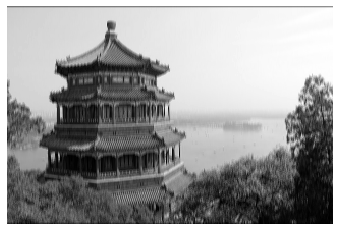

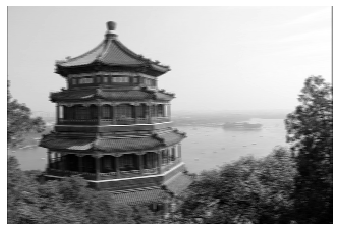

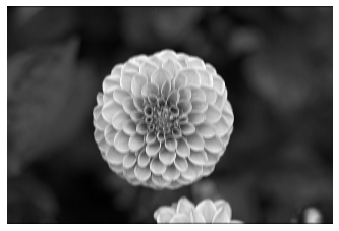

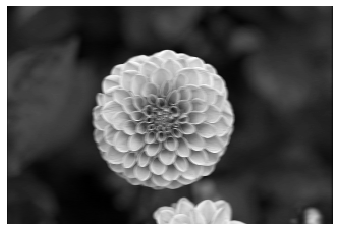

In [11]:
for image_index in (0,1):
  for feature_map_index in (0,1):
    plot_image(output[image_index,:,:,feature_map_index])
    plt.show()

Using tf.layers.conv2d():



In [12]:
reset_graph()

X=tf.placeholder(shape=(None,height,width,channels),dtype=tf.float32)
conv=tf.layers.conv2d(X,filters=2,kernel_size=7,strides=[2,2],padding="SAME")

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.


In [0]:
init=tf.global_variables_initializer()

with tf.Session() as sess:
  init.run()
  output=sess.run(conv,feed_dict={X:dataset})

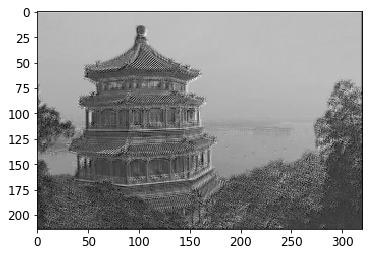

In [14]:
plt.imshow(output[0,:,:,1],cmap="gray")
plt.show()

VALID vs SAME padding

In [15]:
reset_graph()

filter_primes=np.array([2.,3.,5.,7.,11.,13.], dtype=np.float32)
x=tf.constant(np.arange(1, 13+1, dtype=np.float32).reshape([1,1,13,1]))
filters=tf.constant(filter_primes.reshape(1,6,1,1))

valid_conv=tf.nn.conv2d(x,filters, strides=[1,1,5,1],padding="VALID")
same_conv =tf.nn.conv2d(x,filters,strides=[1,1,5,1],padding="SAME")

with tf.Session() as sess:
  print("VALID:\n",valid_conv.eval())
  print("SAME:\n",same_conv.eval())

VALID:
 [[[[184.]
   [389.]]]]
SAME:
 [[[[143.]
   [348.]
   [204.]]]]


In [16]:
print("VALID:")
print(np.array([1,2,3,4,5,6]).T.dot(filter_primes))
print(np.array([6,7,8,9,10,11]).T.dot(filter_primes))
print("SAME:")
print(np.array([0,1,2,3,4,5]).T.dot(filter_primes))
print(np.array([5,6,7,8,9,10]).T.dot(filter_primes))
print(np.array([10,11,12,13,0,0]).T.dot(filter_primes))

VALID:
184.0
389.0
SAME:
143.0
348.0
204.0


Pooling layer

In [0]:

batch_size, height, width, channels = dataset.shape

filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

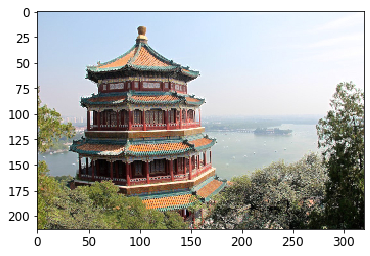

In [18]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")

with tf.Session() as sess:
    output = sess.run(max_pool, feed_dict={X: dataset})

plt.imshow(output[0].astype(np.uint8))  # plot the output for the 1st image
plt.show()

china_original


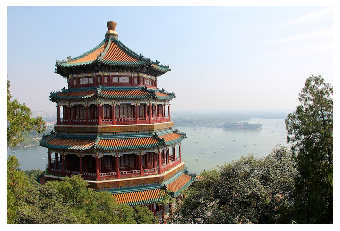

china_max_pool


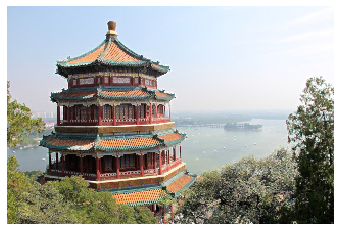

In [19]:
plot_color_image(dataset[0])
print("china_original")
plt.show()
    
plot_color_image(output[0])
print("china_max_pool")
plt.show()

MNIST

Note: instead of using the fully_connected(), conv2d() and dropout() functions from the tensorflow.contrib.layers module (as in the book), we now use the dense(), conv2d() and dropout() functions (respectively) from the tf.layers module, which did not exist when this chapter was written. This is preferable because anything in contrib may change or be deleted without notice, while tf.layers is part of the official API. As you will see, the code is mostly the same.

For all these functions:

the scope parameter was renamed to name, and the _fn suffix was removed in all the parameters that had it (for example the activation_fn parameter was renamed to activation).

The other main differences in tf.layers.dense() are:

the weights parameter was renamed to kernel (and the weights variable is now named "kernel" rather than "weights"),
the default activation is None instead of tf.nn.relu

The other main differences in tf.layers.conv2d() are:

the num_outputs parameter was renamed to filters,
the stride parameter was renamed to strides,
the default activation is now None instead of tf.nn.relu.

The other main differences in tf.layers.dropout() are:

it takes the dropout rate (rate) rather than the keep probability (keep_prob). Of course, rate == 1 - keep_prob,
the is_training parameters was renamed to training.

In [20]:
height = 28
width = 28
channels = 1
n_inputs = height * width

conv1_fmaps = 32
conv1_ksize = 3
conv1_stride = 1
conv1_pad = "SAME"

conv2_fmaps = 64
conv2_ksize = 3
conv2_stride = 2
conv2_pad = "SAME"

pool3_fmaps = conv2_fmaps

n_fc1 = 64
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.relu, name="conv1")
conv2 = tf.layers.conv2d(conv1, filters=conv2_fmaps, kernel_size=conv2_ksize,
                         strides=conv2_stride, padding=conv2_pad,
                         activation=tf.nn.relu, name="conv2")

with tf.name_scope("pool3"):
    pool3 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    pool3_flat = tf.reshape(pool3, shape=[-1, pool3_fmaps * 7 * 7])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool3_flat, n_fc1, activation=tf.nn.relu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

Instructions for updating:
Use keras.layers.Dense instead.


In [21]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [23]:
n_epochs = 10
batch_size = 100

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
        print(epoch, "Last batch accuracy:", acc_batch, "Test accuracy:", acc_test)

        save_path = saver.save(sess, "./my_mnist_model")

0 Last batch accuracy: 0.99 Test accuracy: 0.9778
1 Last batch accuracy: 0.98 Test accuracy: 0.9838
2 Last batch accuracy: 0.98 Test accuracy: 0.9792
3 Last batch accuracy: 0.99 Test accuracy: 0.9893
4 Last batch accuracy: 0.99 Test accuracy: 0.9879
5 Last batch accuracy: 1.0 Test accuracy: 0.9886
6 Last batch accuracy: 0.99 Test accuracy: 0.9889
7 Last batch accuracy: 1.0 Test accuracy: 0.99
8 Last batch accuracy: 1.0 Test accuracy: 0.9886
9 Last batch accuracy: 1.0 Test accuracy: 0.99
